In [ ]:
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import activations

In [ ]:
#Import Binance API price data
priceFile = open("PRICES_-1.txt", "rb")
pricesResponse = pickle.load(priceFile)
prices = pd.DataFrame.from_dict(pricesResponse.json())

In [ ]:
#Import CSV price data
prices = pd.read_csv('ETHUSD 1-1-17 to 5-28-22.csv', engine='python')

In [ ]:
prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...,...
1657,2022-05-24,1972.390869,1991.535522,1920.688110,1978.982788,1978.982788,13057109007
1658,2022-05-25,1978.677002,2014.369507,1943.938599,1944.827881,1944.827881,13364545730
1659,2022-05-26,1945.033325,1962.171143,1759.199585,1803.913330,1803.913330,23458681818
1660,2022-05-27,1802.543823,1814.656494,1721.264771,1724.922852,1724.922852,25470760032


In [ ]:
trainingNum = int(len(prices) * 0.75)
trainingData = prices[:trainingNum]
testData = prices[trainingNum:]

In [ ]:
trainingData

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...,...
1241,2021-04-03,2142.895996,2144.962402,2028.422485,2028.422485,2028.422485,32011518871
1242,2021-04-04,2027.671265,2110.353516,2007.111816,2093.122803,2093.122803,26006501902
1243,2021-04-05,2093.260742,2140.985352,2032.387695,2107.887207,2107.887207,28889391170
1244,2021-04-06,2109.493164,2151.223389,2057.609131,2118.378906,2118.378906,29222865881


In [ ]:
trainingData.iloc[854]
#This day had the largest percentage drop during this selected time period

Date          2020-03-12
Open          194.738922
High          195.147934
Low           111.210709
Close         112.347122
Adj Close     112.347122
Volume       22134741655
Name: 854, dtype: object

In [282]:
openPrices = trainingData[['Open']]
openPrices.index = trainingData[['Date']]
closePrices = trainingData[['Close']]
closePrices.index = trainingData[['Date']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

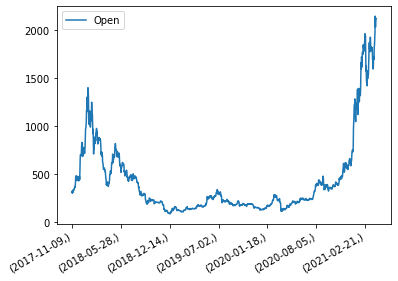

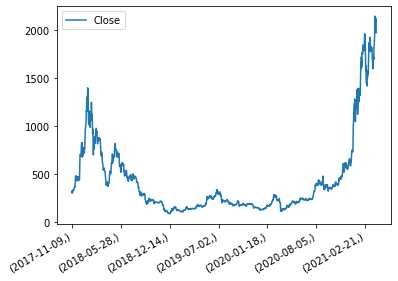

In [280]:
openPrices.plot()
plt.setp(plt.axes().get_xticklabels(), rotation=30, horizontalalignment='right')
closePrices.plot()
plt.setp(plt.axes().get_xticklabels(), rotation=30, horizontalalignment='right')

In [ ]:
#Parse CSV data
#Get log return
def getLogReturns(data):
  logReturns = []
  for i in data.index:
    logReturns.append(math.log(data['Close'][i]) - math.log(data['Open'][i]))
  return pd.Series(logReturns)

#Get log range
def getLogRanges(data):
  logRanges = []
  for i in data.index:
    logRanges.append(math.log(data['High'][i]) - math.log(data['Low'][i]))
  return pd.Series(logRanges)

#Get log quadratic variation
def getLogQuadraticVariations(logReturns, look_back = 10):
  logQuadraticVariations = []
  cumQuadraticVariations = 0
  for i in range(10):
    sqRet = logReturns[i] ** 2
    cumQuadraticVariations += sqRet
  logQV = math.log(cumQuadraticVariations)
  logQuadraticVariations.append(logQV)
  for i in range(10, len(logReturns)):
    newLogQV = math.exp(logQV)
    newLogQV -= logReturns[i - 10] ** 2
    newLogQV += logReturns[i] ** 2
    newLogQV = math.log(newLogQV)
    logQuadraticVariations.append(newLogQV)
    logQV = newLogQV
  return logQuadraticVariations

logRets = getLogReturns(trainingData)
logRans = getLogRanges(trainingData)
logQVs = getLogQuadraticVariations(logRets)

testLogRets = getLogReturns(testData)
testLogRans = getLogRanges(testData)
testLogQVs = getLogQuadraticVariations(testLogRets)

In [226]:
"""
Augmented Dickey-Fuller Test:
Given a time series data, the augmented dickey-fuller test provides a check on whether the data is stationary or non-stationary.
Stationary means the data does not depend on time, i.e. there are no seasonal variations, or trends over time
The adfuller test produces a p-value:
a p-value > 0.05 fails to reject the null hypothesis and is thus non-stationary
a p-value <= 0.05 rejects the null hypothesis and is thus stationary
The ADF statistic provides a measure of how likely the given data is to be a statistical fluke: the more negative, the less likely
The Critical Values provide some ranges for the significance level of the ADF statistic
e.g. an ADF statistic of -4 with critical values 1%: -5 and 5%: -3 means the significance level is between 1-5%, so the probability
that the given data is a statistical fluke is between 1-5%
"""

def getAdFuller(data):
  result = adfuller(data)
  print('p-value: ', result[1])
  print('ADF Statistic: ', result[0])
  print('Critical Values:')
  for key, val in result[4].items():
    print(f'{key}: {val}')
  print("")

getAdFuller(logRets)
getAdFuller(logRans)
getAdFuller(logQVs)

p-value:  0.0
ADF Statistic:  -23.43996565930477
Critical Values:
1%: -3.4356175602072545
5%: -2.8638661490437025
10%: -2.5680084710921105

p-value:  1.2828148543213315e-05
ADF Statistic:  -5.1191446086876375
Critical Values:
1%: -3.4356819860439574
5%: -2.863894574114006
10%: -2.568023609111511

p-value:  0.00016670796702767925
ADF Statistic:  -4.539531307077029
Critical Values:
1%: -3.435739110194116
5%: -2.863919777127088
10%: -2.5680370312770515



In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaledLogRets = scaler.fit_transform(logRets.to_frame())
scaledLogRans = scaler.fit_transform(logRans.to_frame())

scaledTestLogRets = scaler.fit_transform(testLogRets.to_frame())
scaledTestLogRans = scaler.fit_transform(testLogRans.to_frame())

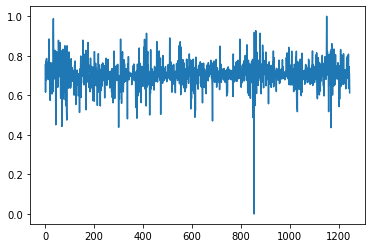

In [ ]:
plt.plot(scaledLogRets)

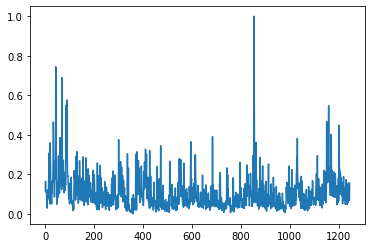

In [ ]:
plt.plot(scaledLogRans)

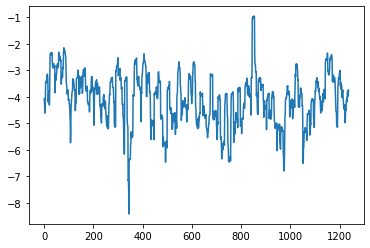

In [ ]:
plt.plot(logQVs)

In [ ]:
#Courtesy of https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
def create_samples(rets, rans, look_back = 30):
  dataX = []
  for i in range(len(rets) - look_back - 1):
    a = rets[i:(i+look_back), 0] + rans[i:(i+look_back), 0]
    dataX.append(a)
  return np.array(dataX)

ins = create_samples(scaledLogRets, scaledLogRans)
testIns = create_samples(scaledTestLogRets, scaledTestLogRans)

In [ ]:
ins = ins.reshape(ins.shape[0], 1, ins.shape[1])
outs = np.array(logQVs[22:])

testIns = testIns.reshape(testIns.shape[0], 1, testIns.shape[1])
testOuts = np.array(testLogQVs[22:])

In [ ]:
model = Sequential()
model.add(LSTM(20, input_shape=(ins.shape[1], ins.shape[2])))
model.add(Dropout(0.1, input_shape=(ins.shape[1], ins.shape[2])))
model.add(Dense(10))
model.add(Dropout(0.1, input_shape=(ins.shape[1], ins.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(ins, outs, epochs=50, batch_size=30, validation_data=(testIns, testOuts), verbose=2, shuffle=False)

Epoch 1/50
41/41 - 4s - loss: 2.8721 - val_loss: 1.5867 - 4s/epoch - 99ms/step
Epoch 2/50
41/41 - 0s - loss: 0.9541 - val_loss: 0.6496 - 156ms/epoch - 4ms/step
Epoch 3/50
41/41 - 0s - loss: 1.0616 - val_loss: 0.6482 - 157ms/epoch - 4ms/step
Epoch 4/50
41/41 - 0s - loss: 1.0418 - val_loss: 0.6455 - 152ms/epoch - 4ms/step
Epoch 5/50
41/41 - 0s - loss: 1.0165 - val_loss: 0.6446 - 144ms/epoch - 4ms/step
Epoch 6/50
41/41 - 0s - loss: 1.0071 - val_loss: 0.6364 - 146ms/epoch - 4ms/step
Epoch 7/50
41/41 - 0s - loss: 0.9897 - val_loss: 0.6220 - 169ms/epoch - 4ms/step
Epoch 8/50
41/41 - 0s - loss: 0.9884 - val_loss: 0.6168 - 200ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.9888 - val_loss: 0.6405 - 141ms/epoch - 3ms/step
Epoch 10/50
41/41 - 0s - loss: 0.9940 - val_loss: 0.6131 - 143ms/epoch - 3ms/step
Epoch 11/50
41/41 - 0s - loss: 0.9748 - val_loss: 0.6061 - 142ms/epoch - 3ms/step
Epoch 12/50
41/41 - 0s - loss: 0.9786 - val_loss: 0.6066 - 146ms/epoch - 4ms/step
Epoch 13/50
41/41 - 0s - lo

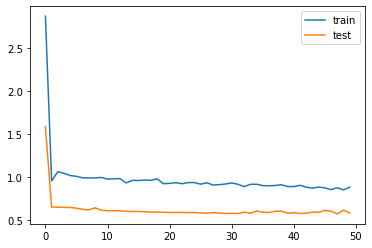

In [186]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [215]:
outHat = model.predict(testIns)
predictTestIns = testIns.reshape((testIns.shape[0], testIns.shape[2]))
invOutHat = np.concatenate((outHat, predictTestIns[:, 1:]), axis=1)
invOutHat = scaler.inverse_transform(invOutHat)
invOutHat = invOutHat[:,0]

predictTestOuts = testOuts.reshape((len(testOuts), 1))
invTestOuts = np.concatenate((predictTestOuts, predictTestIns[:, 1:]), axis=1)
invTestOuts = scaler.inverse_transform(invTestOuts)
invTestOuts = invTestOuts[:,0]

rmse = math.sqrt(mean_squared_error(invTestOuts, invOutHat))
print("RMSE: ", rmse)

nrmse = (rmse / (np.amax(invTestOuts) - np.amin(invTestOuts))) * 100
print("Normalized RMSE: ", nrmse, "%")

RMSE:  0.42043761557164544
Normalized RMSE:  16.804846305426484 %


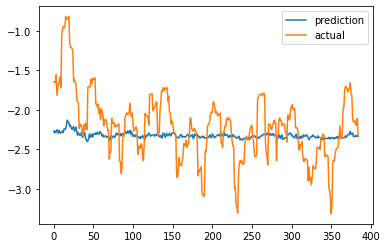

In [197]:
plt.plot(invOutHat, label='prediction')
plt.plot(invTestOuts, label='actual')
plt.legend()